In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [98]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [99]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

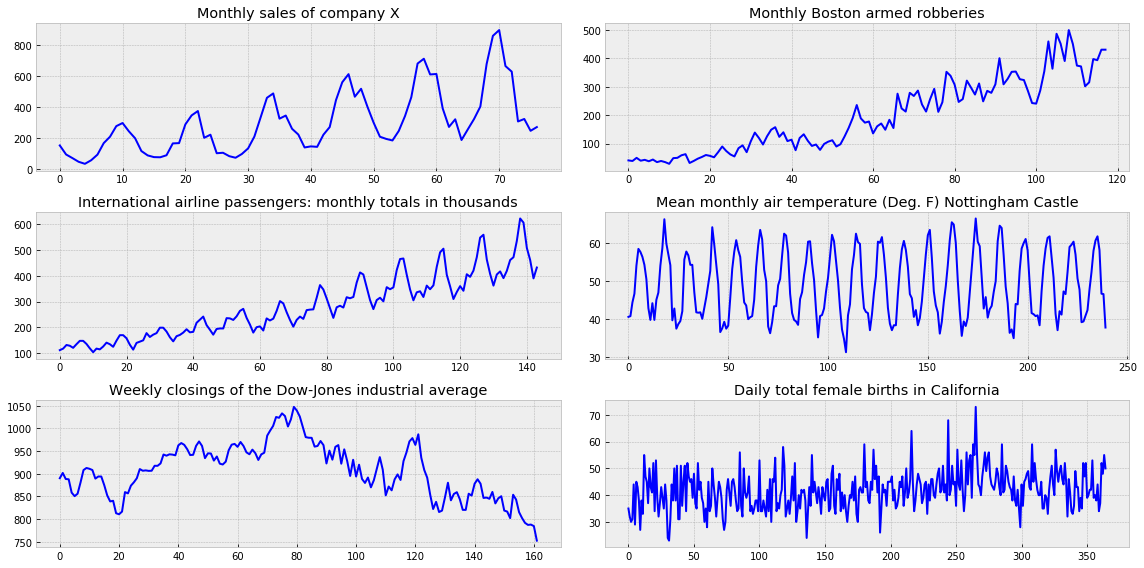

In [100]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [101]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [102]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# Weekly closings of the Dow-Jones industrial average


In [103]:
series_not_stationary = all_series["Weekly closings of the Dow-Jones industrial average"]
test_stationarity(series_not_stationary)

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


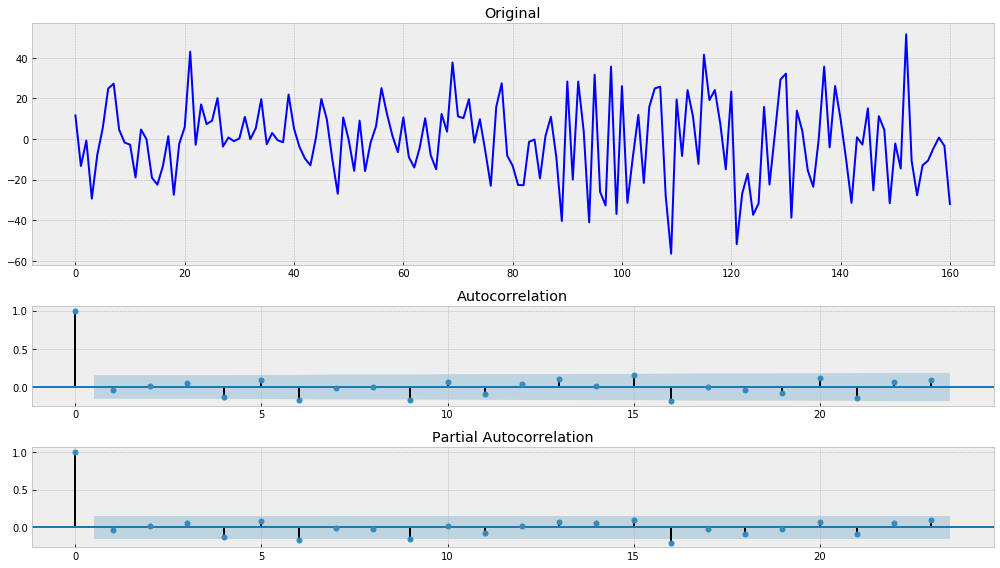

In [104]:
series_stationary = np.diff(series_not_stationary, 1)
series_stationary = pd.Series(series_stationary)
tsplot(series_stationary) 

In [105]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

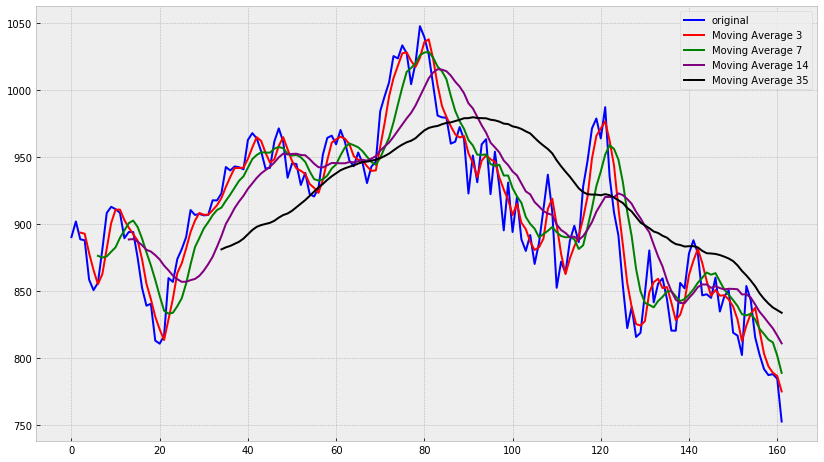

In [167]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_not_stationary, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series_not_stationary, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

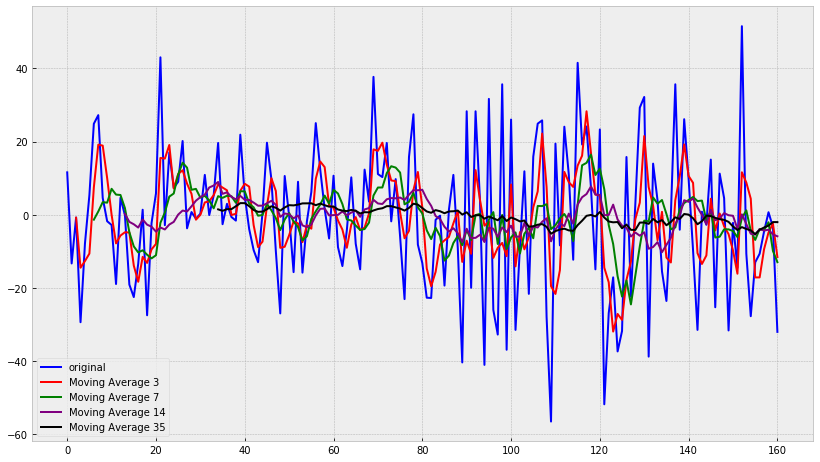

In [111]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stationary, color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(series_stationary, windows[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Взвешенная скользящая средняя

In [112]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

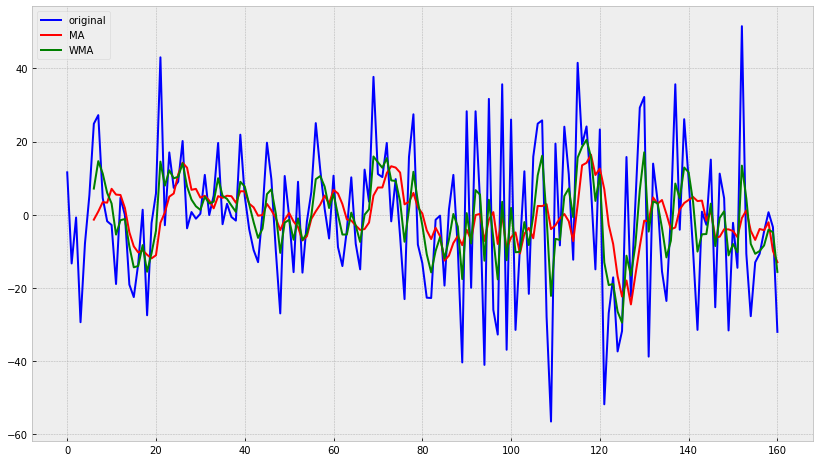

In [113]:
wma = weighted_moving_average(series_stationary, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_stationary, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stationary, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

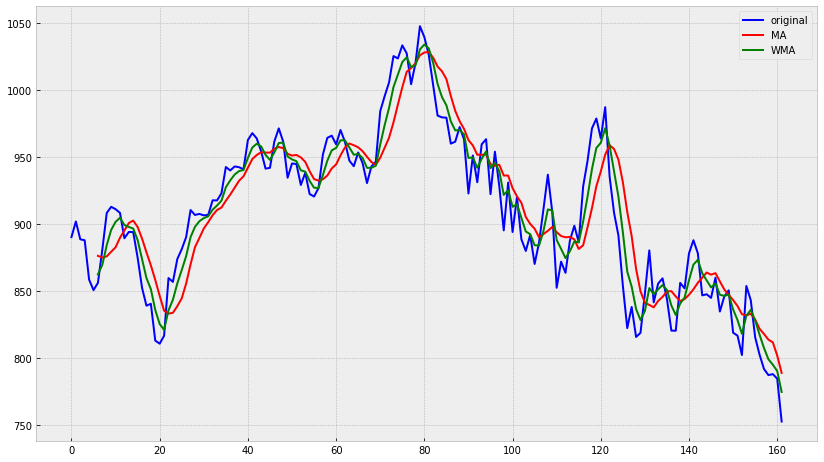

In [114]:
wma = weighted_moving_average(series_not_stationary, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_not_stationary, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_not_stationary, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

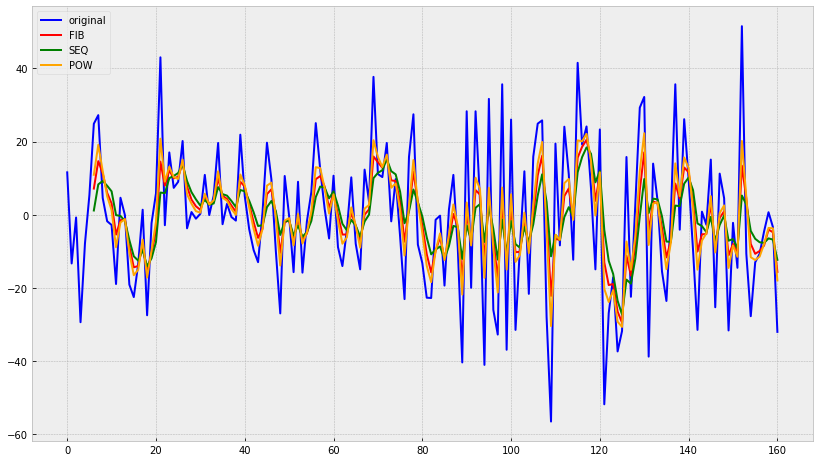

In [115]:
wma_fib = weighted_moving_average(series_stationary, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series_stationary, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series_stationary, 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stationary, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

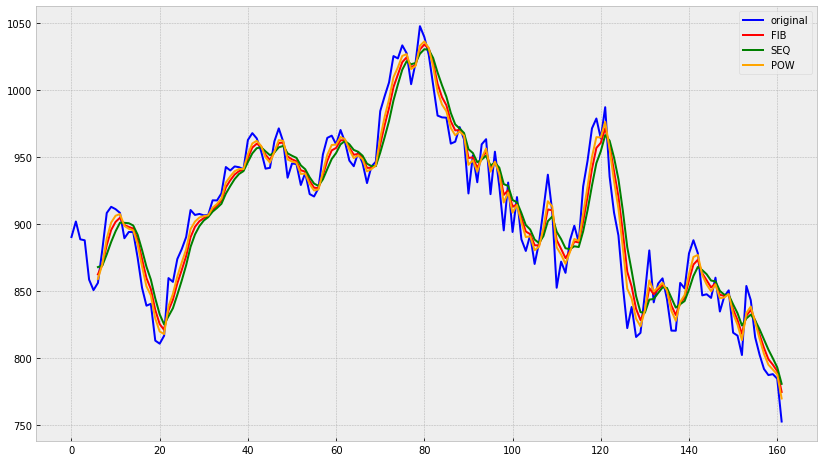

In [116]:
wma_fib = weighted_moving_average(series_not_stationary, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series_not_stationary, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series_not_stationary, 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_not_stationary, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

экспоненциальное скользящее среднее.

In [117]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

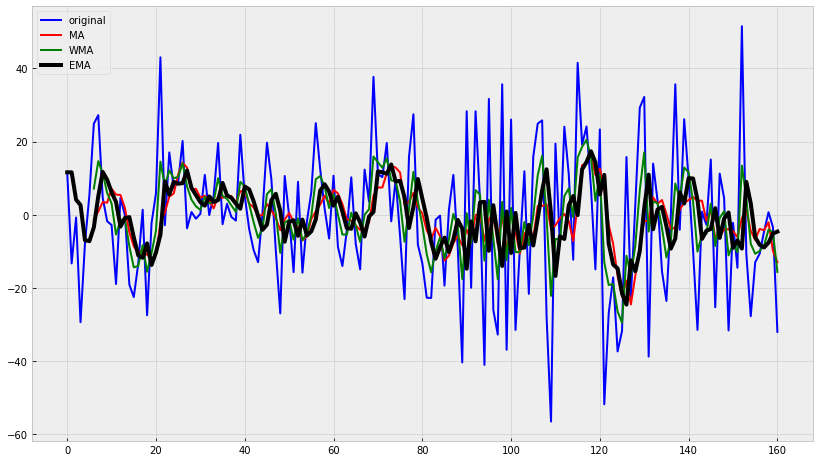

In [149]:
ema = exponential_moving_average(series_stationary, 0.3)
wma = weighted_moving_average(series_stationary, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_stationary, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stationary, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

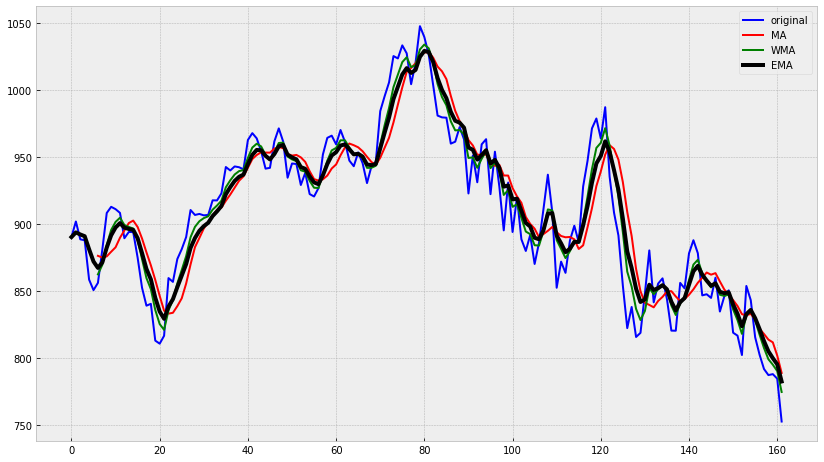

In [119]:
ema = exponential_moving_average(series_not_stationary, 0.3)
wma = weighted_moving_average(series_not_stationary, 7, [1,1,2,3,5,8,13])
ma = moving_average(series_not_stationary, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_not_stationary, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

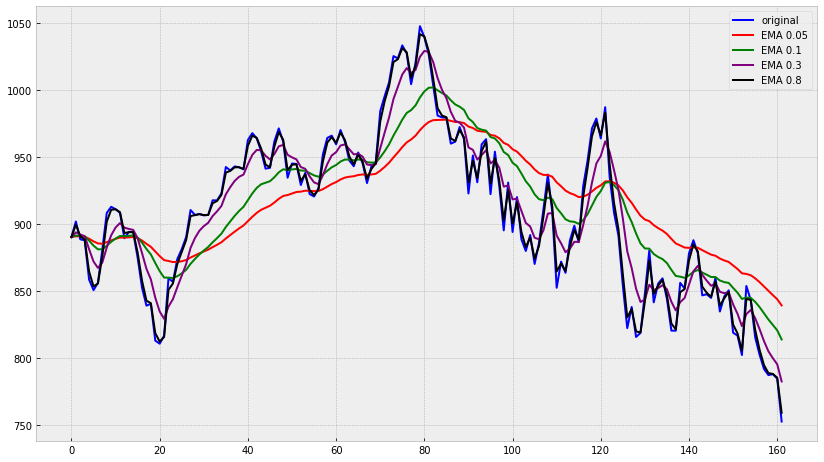

In [120]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_not_stationary, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series_not_stationary, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

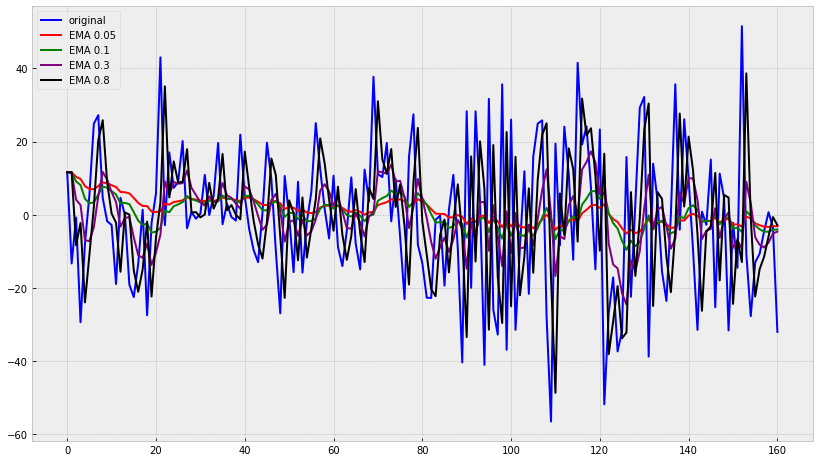

In [168]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_stationary, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series_stationary, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Двойное экспоненциальное сглаживание.

In [243]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [244]:
def plot_dema(alpha, beta, base_plot=series_not_stationary):
    dema = double_ema(base_plot, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(base_plot, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [245]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [246]:
train, test, val = series_not_stationary[:60], series_not_stationary[60:70], series_not_stationary[70:]

In [247]:
def mse(X):
    alpha, beta = X
    result = double_ema(train, alpha, beta)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

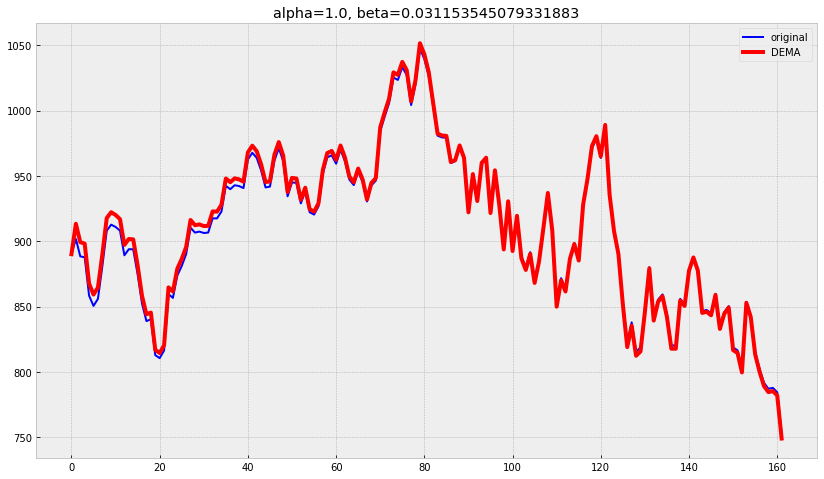

In [261]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt.x
plot_dema(alpha_opt, beta_opt)

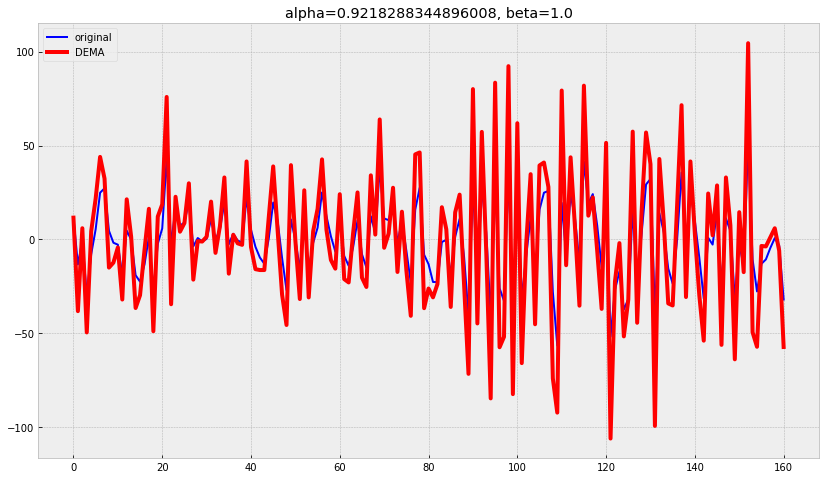

In [264]:
train, val = series_stationary[:65], series_stationary[65:]
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt.x
plot_dema(alpha_opt, beta_opt, base_plot=series_stationary)

Итог:
Я изучал график индекса Доу-Джонса, лучшее приближение дают след. методы (порядок указан по мере убывания приближения к исходному графику):
1. Двойное экспоненциальное сглаживание.  
2. Экспоненциальное скользящее среднее с alpha=0.8.   
3. Взвешенная скользящая средняя c весами, составляющие степени 2. 